In [102]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [103]:
train_path = "/kaggle/input/african/Train.csv"
test_path = "/kaggle/input/african/Test.csv"
macro_path = "/kaggle/input/economic/economic_indicators.csv"

In [104]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [105]:
def preprocess_data():
    data = pd.concat([train, test]).reset_index(drop=True)

    data['disbursement_date'] = pd.to_datetime(data['disbursement_date'], errors='coerce')
    data['due_date'] = pd.to_datetime(data['due_date'], errors='coerce')
    
    date_cols = ['disbursement_date', 'due_date']
    for col in date_cols:
        data[col] = pd.to_datetime(data[col])
        data[col+'_month'] = data[col].dt.month
        data[col+'_day'] = data[col].dt.day
        data[col+'_year'] = data[col].dt.year
        data[f'loan_term_days'] = (data['due_date'] - data['disbursement_date']).dt.days
        data[f'disbursement_weekday'] = data['disbursement_date'].dt.weekday
        data[f'due_weekday'] = data['due_date'].dt.weekday
    
    data['repayment_ratio'] = data['Total_Amount_to_Repay'] / data['Total_Amount']
    data['log_Total_Amount'] = np.log1p(data['Total_Amount'])
    data['interest_rate'] = (data['Total_Amount_to_Repay'] - data['Total_Amount']) / data['Total_Amount'] * 100
    
    cat_cols = data.select_dtypes(include='object').columns
    data = pd.get_dummies(data, columns=['loan_type'], prefix='loan_type', drop_first=False)
    loan_type_cols = [col for col in data.columns if col.startswith('loan_type_')]
    data[loan_type_cols] = data[loan_type_cols].astype(int)
    
    le = LabelEncoder()
    for col in [col for col in cat_cols if col not in ['loan_type', 'ID']]:
        data[col] = le.fit_transform(data[col])
    
    train_df = data[data['ID'].isin(train['ID'].unique())]
    test_df = data[data['ID'].isin(test['ID'].unique())]
    
    features_for_modelling = [col for col in train_df.columns if col not in date_cols + ['ID', 'target', 'country_id']]

    return train_df, test_df, features_for_modelling

In [106]:
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def find_optimal_threshold(predictions, y_true):
    thresholds = np.arange(0.1, 0.9, 0.02)
    best_threshold = 0.5
    best_f1 = 0.0
    
    for threshold in thresholds:
        pred_labels = (predictions > threshold).astype(int)
        f1 = f1_score(y_true, pred_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            
    return best_threshold, best_f1

In [116]:
def create_model(input_dim):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(input_dim,)),
        layers.BatchNormalization(),
        
        # First layer - increased capacity
        layers.Dense(64, 
                    kernel_initializer='he_normal',
                    kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Second layer
        layers.Dense(32,
                    kernel_initializer='he_normal',
                    kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(1, activation='sigmoid',
                    bias_initializer=tf.keras.initializers.Constant(np.log(956/50534)))
    ])
    return model


def train_with_kfold(X, y, features_for_modelling, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Initialize lists to store results
    models = []
    scalers = []
    thresholds = []
    f1_scores = []
    
    # Convert y to numpy array and ensure it's binary
    y = np.array(y).astype(int)
    
    # For each fold
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\nTraining fold {fold + 1}/{n_splits}")
        
        # Split data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Print class distribution for debugging
        print("Training set class distribution:", np.bincount(y_train))
        print("Validation set class distribution:", np.bincount(y_val))
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Create and compile model
        model = create_model(len(features_for_modelling))
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )
        
        # Calculate class weights
        n_neg = np.sum(y_train == 0)
        n_pos = np.sum(y_train == 1)
        total = len(y_train)
        
        class_weights = {
            0: total / (2.0 * n_neg),
            1: total / (2.0 * n_pos)
        }
        
        print("Class weights:", class_weights)
        
        # Callbacks
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        
        # Train model
        history = model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=100,
            batch_size=128,
            class_weight=class_weights,
            callbacks=[early_stopping],
            verbose=1
        )
        
        # Find optimal threshold for this fold
        val_pred = model.predict(X_val_scaled)
        threshold, f1 = find_optimal_threshold(val_pred, y_val)
        
        print(f"Fold {fold + 1} - Best threshold: {threshold:.3f}, F1-score: {f1:.4f}")
        
        # Store results
        models.append(model)
        scalers.append(scaler)
        thresholds.append(threshold)
        f1_scores.append(f1)
    
    # Print summary
    print("\nCross-validation summary:")
    print(f"Mean F1-score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"Mean threshold: {np.mean(thresholds):.4f} ± {np.std(thresholds):.4f}")
    
    return models, scalers, thresholds, f1_scores

In [108]:
train_df, test_df, features_for_modelling = preprocess_data()

X_train, X_val, y_train, y_val = train_test_split(
    train_df[features_for_modelling], 
    train_df['target'], 
    random_state=42
)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(51490, 46) (17164, 46) (51490,) (17164,)


In [117]:
models, scalers, thresholds, f1_scores = train_with_kfold(
    X_train, y_train, features_for_modelling
)


Training fold 1/5
Training set class distribution: [40427   765]
Validation set class distribution: [10107   191]
Class weights: {0: 0.5094614985034754, 1: 26.922875816993464}
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


322/322 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9582 - auc: 0.7742 - loss: 2.8350 - val_accuracy: 0.9295 - val_auc: 0.9677 - val_loss: 1.6718
Epoch 2/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9241 - auc: 0.9599 - loss: 1.6520 - val_accuracy: 0.9351 - val_auc: 0.9631 - val_loss: 1.3667
Epoch 3/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9338 - auc: 0.9745 - loss: 1.3237 - val_accuracy: 0.9358 - val_auc: 0.9700 - val_loss: 1.1554
Epoch 4/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9347 - auc: 0.9790 - loss: 1.1127 - val_accuracy: 0.9396 - val_auc: 0.9751 - val_loss: 0.9762
Epoch 5/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9352 - auc: 0.9821 - loss: 0.9378 - val_accuracy: 0.9525 - val_auc: 0.9779 - val_loss: 0.7894
Epoch 6/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9431 - auc: 0.9823 - loss: 0.7953 - val_accuracy: 0.9431 - val_auc: 0.9803 - val_loss: 0.6910
Epoch 7/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3m

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


322/322 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9453 - auc: 0.8791 - loss: 2.4761 - val_accuracy: 0.9282 - val_auc: 0.9786 - val_loss: 1.5468
Epoch 2/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9263 - auc: 0.9677 - loss: 1.5217 - val_accuracy: 0.9346 - val_auc: 0.9818 - val_loss: 1.2157
Epoch 3/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9282 - auc: 0.9778 - loss: 1.1912 - val_accuracy: 0.9575 - val_auc: 0.9845 - val_loss: 0.9496
Epoch 4/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9306 - auc: 0.9788 - loss: 0.9662 - val_accuracy: 0.9497 - val_auc: 0.9830 - val_loss: 0.7792
Epoch 5/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9319 - auc: 0.9821 - loss: 0.7778 - val_accuracy: 0.9511 - val_auc: 0.9854 - val_loss: 0.6373
Epoch 6/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9374 - auc: 0.9834 - loss: 0.6434 - val_accuracy: 0.9407 - val_auc: 0.9845 - val_loss: 0.5565
Epoch 7/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3m

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


322/322 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9568 - auc: 0.7615 - loss: 2.9306 - val_accuracy: 0.9260 - val_auc: 0.9801 - val_loss: 1.6738
Epoch 2/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9321 - auc: 0.9725 - loss: 1.6020 - val_accuracy: 0.9358 - val_auc: 0.9873 - val_loss: 1.3071
Epoch 3/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9336 - auc: 0.9744 - loss: 1.3058 - val_accuracy: 0.9447 - val_auc: 0.9901 - val_loss: 1.0532
Epoch 4/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9347 - auc: 0.9770 - loss: 1.0659 - val_accuracy: 0.9605 - val_auc: 0.9912 - val_loss: 0.8584
Epoch 5/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9424 - auc: 0.9842 - loss: 0.8610 - val_accuracy: 0.9558 - val_auc: 0.9917 - val_loss: 0.7151
Epoch 6/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9360 - auc: 0.9808 - loss: 0.7482 - val_accuracy: 0.9703 - val_auc: 0.9926 - val_loss: 0.5809
Epoch 7/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3m

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


322/322 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9579 - auc: 0.8874 - loss: 2.3852 - val_accuracy: 0.9460 - val_auc: 0.9864 - val_loss: 1.5452
Epoch 2/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9309 - auc: 0.9749 - loss: 1.5178 - val_accuracy: 0.9453 - val_auc: 0.9851 - val_loss: 1.2065
Epoch 3/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9345 - auc: 0.9752 - loss: 1.2085 - val_accuracy: 0.9508 - val_auc: 0.9871 - val_loss: 0.9633
Epoch 4/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9348 - auc: 0.9792 - loss: 0.9750 - val_accuracy: 0.9719 - val_auc: 0.9895 - val_loss: 0.7690
Epoch 5/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9385 - auc: 0.9799 - loss: 0.8081 - val_accuracy: 0.9392 - val_auc: 0.9858 - val_loss: 0.6768
Epoch 6/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9317 - auc: 0.9796 - loss: 0.6856 - val_accuracy: 0.9522 - val_auc: 0.9907 - val_loss: 0.5521
Epoch 7/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3m

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


322/322 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9599 - auc: 0.8002 - loss: 2.7892 - val_accuracy: 0.9410 - val_auc: 0.9780 - val_loss: 1.6366
Epoch 2/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9256 - auc: 0.9663 - loss: 1.6002 - val_accuracy: 0.9421 - val_auc: 0.9900 - val_loss: 1.2599
Epoch 3/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9293 - auc: 0.9765 - loss: 1.2407 - val_accuracy: 0.9546 - val_auc: 0.9923 - val_loss: 0.9858
Epoch 4/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9322 - auc: 0.9802 - loss: 0.9858 - val_accuracy: 0.9457 - val_auc: 0.9888 - val_loss: 0.8031
Epoch 5/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9311 - auc: 0.9741 - loss: 0.8268 - val_accuracy: 0.9632 - val_auc: 0.9946 - val_loss: 0.6345
Epoch 6/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9373 - auc: 0.9836 - loss: 0.6567 - val_accuracy: 0.9664 - val_auc: 0.9940 - val_loss: 0.5239
Epoch 7/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3m

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(15, 5))
# plt.subplot(1, 3, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.legend()
# plt.title('Loss Curves')

# plt.subplot(1, 3, 2)
# plt.plot(history.history['auc'], label='Training AUC')
# plt.plot(history.history['val_auc'], label='Validation AUC')
# plt.legend()
# plt.title('AUC Curves')

In [118]:
def make_ensemble_predictions(models, scalers, thresholds, test_data, features_for_modelling):
    all_predictions = []
    
    for model, scaler, threshold in zip(models, scalers, thresholds):
        X_test_scaled = scaler.transform(test_data[features_for_modelling])
        pred_proba = model.predict(X_test_scaled)
        pred_binary = (pred_proba > threshold).astype(int)
        all_predictions.append(pred_binary)
    
    ensemble_predictions = np.round(np.mean(all_predictions, axis=0)).astype(int)
    
    print("\nEnsemble prediction distribution:")
    print(np.bincount(ensemble_predictions.ravel()))
    
    output = pd.DataFrame({
        'ID': test_data['ID'],
        'target': ensemble_predictions.ravel()
    })
    
    return output

In [119]:
output = make_ensemble_predictions(
    models, scalers, thresholds, test_df, features_for_modelling
)

582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Ensemble prediction distribution:
[17823   771]


In [120]:
output.to_csv('Test_predictions.csv', index=False)
print("Predictions saved to Test_predictions.csv")

Predictions saved to Test_predictions.csv


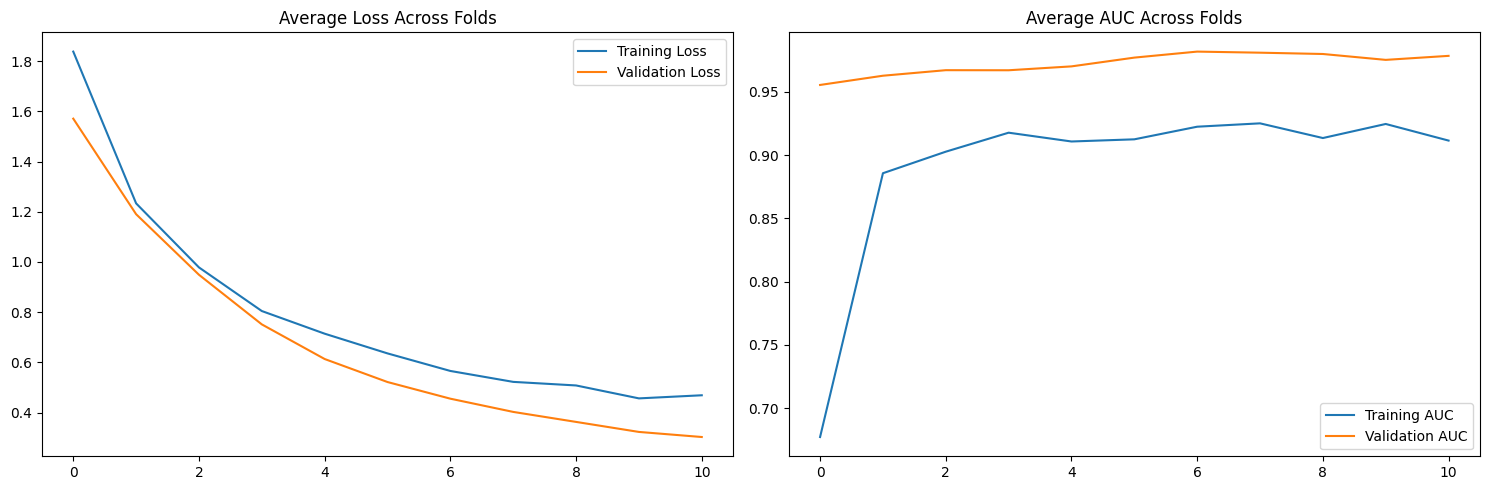

Fold 1 - F1 Score: 0.7338, Threshold: 0.8400
Fold 2 - F1 Score: 0.7343, Threshold: 0.8800
Fold 3 - F1 Score: 0.6863, Threshold: 0.8600
Fold 4 - F1 Score: 0.7807, Threshold: 0.8400
Fold 5 - F1 Score: 0.7871, Threshold: 0.8400


In [122]:
# Store histories during training
histories = []  # Add this line before the fold loop

# Inside the fold loop, after model.fit:
histories.append(history)  # Store the history object

# Then for visualization after training:
plt.figure(figsize=(15, 5))

# Plot average metrics across folds
avg_loss = np.mean([h.history['loss'] for h in histories], axis=0)
avg_val_loss = np.mean([h.history['val_loss'] for h in histories], axis=0)
avg_auc = np.mean([h.history['auc'] for h in histories], axis=0)
avg_val_auc = np.mean([h.history['val_auc'] for h in histories], axis=0)

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(avg_loss, label='Training Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.title('Average Loss Across Folds')
plt.legend()

# AUC plot
plt.subplot(1, 2, 2)
plt.plot(avg_auc, label='Training AUC')
plt.plot(avg_val_auc, label='Validation AUC')
plt.title('Average AUC Across Folds')
plt.legend()

plt.tight_layout()
plt.show()

# Print fold-wise metrics
for i, f1 in enumerate(f1_scores):
    print(f"Fold {i+1} - F1 Score: {f1:.4f}, Threshold: {thresholds[i]:.4f}")